In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from functools import partial

C:\Users\maaya\AppData\Local\Temp\ipykernel_2596\3169132750.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [151]:
df = pd.read_pickle("all_df.pkl")
test_df_original = pd.read_pickle("all_df_test.pkl")

In [152]:
def run_and_eval(model_class, X_train, y_train, X_test, y_test):
    model = model_class()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    X_test_copy = X_test.copy()
    X_test_copy['preds'] = y_pred
    y_pred_per_patient = pd.DataFrame(X_test_copy.groupby('patient id')['preds'].apply(lambda x: (x == 1).any()).astype(int))['preds']
    evaluate_model(y_true=y_test, y_pred=y_pred_per_patient)
    return y_pred

In [153]:
def evaluate_model(y_true,y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    precision = precision_score(y_true, y_pred)
    print("Precision:", precision)
    recall = recall_score(y_true, y_pred)
    print("Recall:", recall)
    f1 = f1_score(y_true, y_pred)
    print("F1 Score:", f1)
    auc = roc_auc_score(y_true, y_pred)
    print("AUC-ROC:", auc)
    mae = mean_absolute_error(y_true, y_pred)
    print("Mean Absolute Error:", mae)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("Root Mean Squared Error:", rmse)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

In [154]:
def outliers_perc_of_col(target, df):
    df_not_null = df[target].dropna()
    Q1 = np.percentile(df_not_null, 25)
    Q3 = np.percentile(df_not_null, 75)
    IQR = Q3 - Q1
    ul = Q3 + 1.5 * IQR
    ll = Q1 - 1.5 * IQR
    outliers = df_not_null[(df_not_null > ul) | (df_not_null < ll)]
    outliers_per = round((len(outliers)/len(df_not_null))*100,2)
    return outliers_per

In [334]:
def prepare_df(df, type_df="train"):
    columns_to_drop = {'DBP', 'SBP','pH','HCO3', 'Hgb', 'Bilirubin_direct', 'EtCO2', 'Fibrinogen', 'TroponinI', 'Unit2'}
    df_processed = df.drop(columns = columns_to_drop)
    df_processed = df_processed.groupby('patient id').apply(lambda x: x.bfill().ffill()).reset_index(drop=True)
    outlier_perc_dict = {}
    for col in df_processed.columns:
        outlier_perc_dict[col] = [outliers_perc_of_col(col, df_processed)]
    outliers_perc_df = pd.DataFrame(outlier_perc_dict).T
    outliers_perc_df.columns = ["Outliers %"]
    outliers_perc_df = outliers_perc_df.sort_values(by=['Outliers %'], ascending=False)
    columns = df_processed.columns
    for col in columns:
        median = df_processed[col].median()
        avg =df_processed[col].mean()
        mode = df_processed[col].mode()[0]
        outlier_perc = outliers_perc_df.loc[col,'Outliers %']
        if df_processed[col].nunique() == 2:
            df_processed[col] = df_processed[col].fillna(mode)
        else:
            if outlier_perc <= 5:
                df_processed[col] = df_processed[col].fillna(avg)
            elif outlier_perc > 5:
                df_processed[col] = df_processed[col].fillna(median)

    if type_df == "train":
        majority_class = df_processed[df_processed['SepsisLabel'] == 0]
        minority_class = df_processed[df_processed['SepsisLabel'] == 1]
        majority_subset = majority_class.sample(n=2*len(minority_class))
        df_processed = df_processed[(df_processed['SepsisLabel'] == 1) | ((df_processed['SepsisLabel'] == 0) & (df_processed.index.isin(majority_subset.index)))].reset_index(drop=True)
    
    X = df_processed.drop('SepsisLabel', axis=1)
    y = df_processed['SepsisLabel']
    
    if type_df == "test":
        y = pd.DataFrame(df_processed.groupby('patient id')['SepsisLabel'].apply(lambda x: (x == 1).any()).astype(int))['SepsisLabel']
    return X, y

In [335]:
X_train, y_train = prepare_df(df, type_df="train")
X_test, y_test = prepare_df(test_df_original, type_df="test")

In [332]:
def add_time_series_cols(x_df, features_to_process, num_hours, y_df=None):
    rows_dict = x_df.groupby('patient id').size().to_dict()
    for feature in features_to_process:
        for hour in range(1, num_hours+1):
            x_df[f'{feature}_before_{hour}_hour'] = x_df.groupby('patient id')[feature].shift(hour)

    for patient_id, num_rows in rows_dict.items():
        if num_rows <= num_hours:
            last_row = x_df[x_df['patient id'] == patient_id].iloc[-1]
            for feature in features_to_process:
                for i in range(num_rows, num_hours+1):
                    if i == 1:
                        val = last_row[feature]
                    else:
                        val = last_row[f'{feature}_before_{i-1}_hour']
                    last_row[f'{feature}_before_{i}_hour'] = val
                    
            for i in range(num_hours - num_rows + 1):
                x_df = pd.concat([x_df, pd.DataFrame(last_row).T], axis=0)
           
    x_df = x_df.groupby('patient id').apply(lambda x: x.iloc[num_hours:])
    x_df = x_df.reset_index(drop=True)
    if y_df is not None:
        y_df = y_df[y_df.index.isin(x_df.index)]
    return x_df, y_df 

In [319]:
mini_df = pd.DataFrame({'patient id': ['A', 'A', 'A', 'A', 'B', 'B', 'C'],
                      'x': ['0', '0', '0', '1', '0', '1', '1']})
mini_df

,patient id,x
0,A,0
1,A,0
2,A,0
3,A,1
4,B,0
5,B,1
6,C,1


In [320]:
res, _ = add_time_series_cols(mini_df, ['x'], 3)
res

,patient id,x,x_before_1_hour,x_before_2_hour,x_before_3_hour
0,A,1,0,0,0
1,B,1,0,0,0
2,C,1,1,1,1


In [336]:
features_to_process = set(X_train.columns) - set(['Age', 'Gender', 'Unit1', 'Unit2','HospAdmTime', 'ICULOS', 'SepsisLabel', 'patient id'])
X_train, y_train = add_time_series_cols(X_train, features_to_process, 3, y_train)
X_test,_ = add_time_series_cols(X_test, features_to_process, 3)

C:\Users\maaya\AppData\Local\Temp\ipykernel_2596\207783653.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_df[f'{feature}_before_{hour}_hour'] = x_df.groupby('patient id')[feature].shift(hour)
C:\Users\maaya\AppData\Local\Temp\ipykernel_2596\207783653.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_df[f'{feature}_before_{hour}_hour'] = x_df.groupby('patient id')[feature].shift(hour)
C:\Users\maaya\AppData\Local\Temp\ipykernel_2596\207783653.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

In [337]:
print(X_train.shape)
print(y_train.shape)

(706884, 106)
(706884,)


Accuracy: 0.9259
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC-ROC: 0.5
Mean Absolute Error: 0.0741
Root Mean Squared Error: 0.272213151776324


c:\users\maaya\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


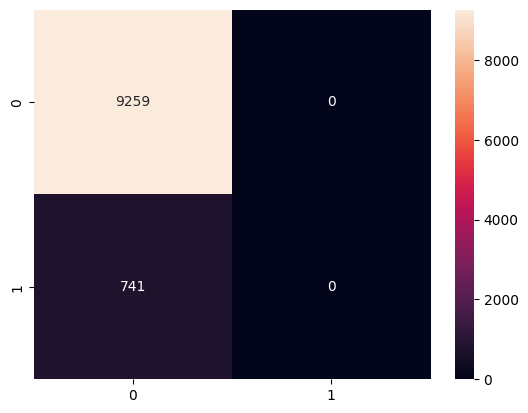

In [340]:
# without under sampling and class weight=balanced and pivoted cols 
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3, class_weight="balanced")
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9343
Precision: 0.64
Recall: 0.2591093117408907
F1 Score: 0.3688760806916426
AUC-ROC: 0.623722492569873
Mean Absolute Error: 0.0657
Root Mean Squared Error: 0.2563201123595259


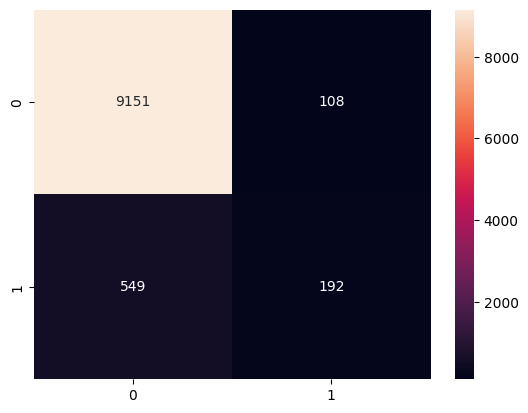

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [118]:
# without under sampling and class weight=balanced, regular schema
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3, class_weight="balanced")
run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9359
Precision: 0.6724137931034483
Recall: 0.2631578947368421
F1 Score: 0.3782735208535402
AUC-ROC: 0.626448803724399
Mean Absolute Error: 0.0641
Root Mean Squared Error: 0.25317977802344327


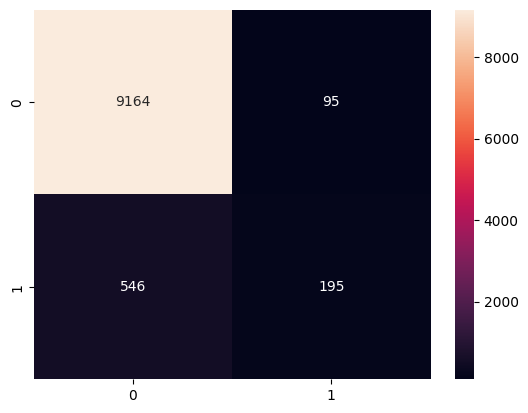

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [115]:
# with under-sampling = 3*minority, regular schema
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3)
run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9238
Precision: 0.4784394250513347
Recall: 0.3144399460188934
F1 Score: 0.3794788273615635
AUC-ROC: 0.643503588950693
Mean Absolute Error: 0.0762
Root Mean Squared Error: 0.2760434748368452


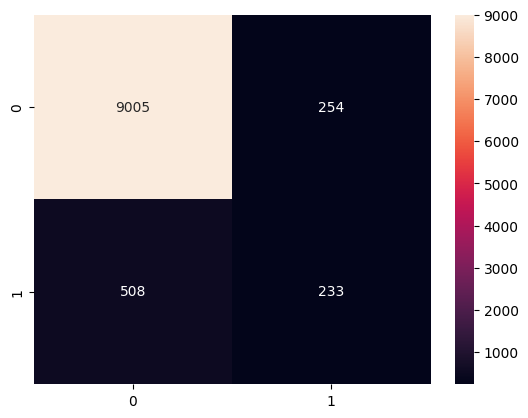

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [108]:
# with under-sampling = 2*minority, regular schema
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3)
run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

In [24]:
features_to_process = set(all_df.columns) - set(['Age', 'Gender', 'Unit1', 'Unit2','HospAdmTime', 'ICULOS', 'SepsisLabel', 'patient id'])

In [43]:
filled_processed_df = add_time_series_cols(filled_df, features_to_process, 5)